## Implementation of t-distributed stochastic neighbor embedding 
focus points: Jax API, implmentation of grad function, vectorized iterations 
Remember to pip install jax

## Coding Resources
See previous notebook "TSNE.ipynb" for past implementation 

https://colab.research.google.com/github/google/flax/blob/main/docs/notebooks/jax_for_the_impatient.ipynb#scrollTo=AoaA-FS2XpsC

https://colab.research.google.com/github/google/jax/blob/main/docs/notebooks/Common_Gotchas_in_JAX.ipynb#scrollTo=PBGI-HIeCP_s

https://scipy-lectures.org/packages/scikit-learn/auto_examples/plot_tsne.html

https://plotly.com/python/t-sne-and-umap-projections/

https://jax.readthedocs.io/en/latest/jax.random.html (jax random documentation)

https://nlml.github.io/in-raw-numpy/in-raw-numpy-t-sne/#eq1 updated template code base for TSNE 

https://lvdmaaten.github.io/tsne/ TSNE coded by the author

https://www.tutorialspoint.com/3d-scatterplots-in-python-matplotlib-with-hue-colormap-and-legend


## Papers
SHEAP
https://journals.aps.org/prx/pdf/10.1103/PhysRevX.11.041026


TSNE
https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf

In [1]:
#/Numpy/
import jax
import jax.numpy as jnp
import numpy as np

#/jax/
from jax import grad
from jax import jit
from jax import random

#/jax/rebinds
import jax.numpy.linalg as la

#/plotting/
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib.colors import ListedColormap

#/debug

## Debugging functions

In [2]:
#Debugging tool to check for dimension
def dim(x):
    print("Dim:")
    print(jnp.shape(x))
    print("\n")

In [3]:
#Debugging tool to check for matrix contents and dimensions
def data_and_dim(x):
    print("Data:\n")
    print(x)
    print("Dim:")
    print(jnp.shape(x))
    print("\n")

## Parameters for tuning TSNE

In [4]:
N = 800                      #Number of observations/data points
PERPLEXITY = 30

#Gradient Descent paramter settings taken from code resources listed above. 
MOMENTUM = 0.9
LEARNING_RATE = 10.
NUM_ITERS = 500             # Num iterations to train for

## Matrix Computation Utilities

In [5]:
@jax.jit
#fill_diagonal function taken from github post by Jax Api author 

def fill_diagonal(a, val):
    assert a.ndim >= 2
    i, j = jnp.diag_indices(min(a.shape[-2:]))
    return a.at[..., i, j].set(val)


## TSNE CODE


Conditional Probability calulation for point neighbor pairs

$$p_{j|i}=\frac{exp(-d(x_i,x_j)^2/2\sigma_i^2}{\sum_{k\neq i} exp[-d(x_i,x_k)^2/2\sigma_i^2]}
$$
Assumption: this algorithm holds for $p_{i|j}$ switching inputs. This is to say 
$$
p_{i|j}=\frac{exp(-d(x_j,x_i)^2/2\sigma_j^2}{\sum_{k\neq j} exp[-d(x_j,x_k)^2/2\sigma_j^2]}
$$

In [6]:
def p_joint(X, target_perplexity):
    print("=======Starting joint probabilities matrix======")
    
    # Get the negative euclidian distances matrix for our data
    print("=======computing distances======")
    distances = negative_norm_squared(X)
    print("Done!")
    
    # Find optimal sigma for each row of this distances matrix
    print("=======computing sigmas======")
    sigmas = find_optimal_sigmas(distances, target_perplexity)
    print("Done!")
    
    # Calculate the probabilities based on these optimal sigmas
    print("=======computing conditionals======")
    p_conditional = calc_prob_matrix(distances, sigmas)
    print("Done!")
    
    # Go from conditional to joint probabilities matrix
    print("=======computing pij's======")
    P = p_conditional_to_joint(p_conditional)
    print("Done!")
        
    return P

In [7]:
# implementation of computation referenced from code resources and stackoverflow post below
@jax.jit
def negative_norm_squared(X):
    
    # https://stackoverflow.com/questions/37009647
    sum_X = jnp.sum(jnp.square(X), 1)
    Distances = jnp.add(jnp.add(-2 * jnp.dot(X, X.T), sum_X).T, sum_X)
    return -Distances

In [8]:
#Softmax function taken from work in code resources, partially understood: Seems to be responding to the structure of the 
# conditional joint probabilities equation
@jax.jit
def softmax(X, diag_zero=True):
    """Take softmax of each row of matrix X."""
    # Subtract max for numerical stability
    e_x = jnp.exp(X - jnp.max(X, axis=1).reshape([-1, 1]))
    
    #Account for pi|i 
    if diag_zero:
        fill_diagonal(e_x, 0.)
        
    # Add a tiny constant for stability of log we take later
    e_x = e_x + 1e-8  # numerical stability
    return e_x / e_x.sum(axis=1).reshape([-1, 1])

$$P_{ij}=\frac{p_{j|i}+p_{i|j{}}}{2N}$$

In [9]:
@jax.jit
def p_conditional_to_joint(P):
    #Compute joing probability matrix using the symmetric nature of the conditional probabilities computed. 
    return (P + P.T) / (2. * P.shape[0])

In [10]:
@jax.jit
def calc_prob_matrix(distances, sigmas=None):
    """normalize computed distances using a calculated sigma"""
    if sigmas is not None:
        two_sig_sq = 2. * jnp.square(sigmas.reshape((-1, 1)))
        #usage of softmax referenced from code resources. Currently this technique is largely not understood
        return softmax(distances / two_sig_sq)
    else:
        print("=======P matrix Calculated======")
        return softmax(distances)

Calculate perplexity using given formula from SHEAP/ TSNE 

$$Perp(P_i)=2^{H(P_i)}$$

Here perplexity is defined as the 2 raised to the power of shannon entropy of the probability matrix.

$$H(P_i)=-\sum_jp_{j|i}\log_2p_{i|j}$$

Perplexity is a smooth measure of the effective number of neighbors of i and is set to the same value for all data points. It is essentially a measurement of how far each point examines its surroundings when describing its local environment. 

In [11]:
def perplexity(distances, sigmas):
    P_i=calc_prob_matrix(distances, sigmas)
    return calc_perplexity(P_i)

$$H(P_i)=-\sum_jp_{j|i}\log_2p_{i|j}$$

In [12]:
@jax.jit
def calc_perplexity(prob_matrix):
    #Calculate the sum along the row 
    H = -jnp.sum(prob_matrix * jnp.log2(prob_matrix), 1)
    #Calculate Target perplexity
    perplexity = 2 ** H
    return perplexity

We wish to compute the optimal sigmas for each row of the probability matrix such that the desired perplexity is attained. This can be done using a binary search to locate the proper sigma for a given row. This gives rise to a relationship between

1. the gaussian centered on $x_i$ 
2. the similarity of each pair $p_{j|i}$
3. Perplexity

As the similarity of the $p_{j|i}$'s increases so too does the perplexity of the problem as the algorithm will be able to fit more $x_j$ under the gaussian centered at $x_i$. This means that to make this happen the gaussian must become flatter with a larger radius from $x_i$. This is done by increasing the given $\sigma_i$ at a $x_i$ which acts as the means of manipulating the gaussian. Since each point may have a different size gaussian necessary to reach target perplexity we observe a relationship between fitting sigma to a target perplexity and the behavior of the gaussian. 

In [13]:
def find_optimal_sigmas(distances, target_perplexity):
  
    #We wish to create a sigma for each row of values so that the perplexity of each row is equal. 
    sigmas = [] 
    # For each row of the matrix (each point in our dataset)
    for i in range(distances.shape[0]):
        if i%5==0:
            print("Processing row:",i)
            
        # Make fn that returns perplexity of this row given sigma
        eval_fn = lambda sigma: \
            perplexity(distances[i:i+1, :], np.array(sigma))
        
        # Use a binary search to locate an optimal sigma for a given row 
        optimized_sig = binary_search(eval_fn, target_perplexity)
        
        # Append the resulting sigma to our output array
        sigmas.append(optimized_sig)
        sigmas
    return jnp.array(sigmas)

In [14]:
def binary_search(eval_fn, target):
    tolerance=1e-10
    max_iter=1000 #make iters higher for larger data         
    lower=1e-20
    upper=1000  
    for i in range(max_iter):
        guess = (lower + upper) / 2.
        val = eval_fn(guess)
        if val > target:
            upper = guess
        else:
            lower = guess
        if jnp.abs(val - target) <= tolerance:
            break
    return guess

Compute " Low dimensional affinities"

$$
q_{ij}=\frac{(1+||y_i-y_j||_2^2)^{-1}}{N(N-1)}
$$

In [15]:
@jax.jit
def q_tsne(Y):
    distances = negative_norm_squared(Y)
    inv_distances = (1. - distances)**-1
    fill_diagonal(inv_distances, 0.)
    return inv_distances / jnp.sum(inv_distances), inv_distances

## Gradient Descent 

Cost Function and gradient : 
$$
C=\sum_i KL(P_i||Q_i)=\sum_i\sum_jp_{i|j}log\frac{p_{i|j}}{q_{j|i}}
$$
$$
\frac{\delta C}{\delta y_i}=4 \sum_j (p_{ij}-q_{ij})(y_i-y_j)(1+||y_i-y_j||_2^2)^{-1})
$$
    

In [16]:

def tsne(X,P):
    print("=======Starting TSNE======")
    """
    # Arguments
        X: Input data matrix.
        P: Matrix of joint probabilities.   
    # Returns:
        Y: Matrix, low-dimensional representation of X.
    """

    # Initialise our output vectors using a sampling of the normal distribution 
    
    Y = random.normal(key, (N, 2))

    # Initialise past values (used for momentum)
    momentum=MOMENTUM
    if momentum:
        Y_m2 = Y
        Y_m1 = Y
        
    """Gradient Descent code referenced from code sources specifically """   
    print("=======Starting Gradient Descent======")

    
    for i in range(NUM_ITERS):
        # Get Q and distances (distances only used for t-SNE)
        Q, distances = q_tsne(Y)
        # Estimate gradients with respect to Y
        grads = tsne_grad(P, Q, Y, distances)

        # Update Y
        Y = Y - LEARNING_RATE * grads
        if momentum:  # Add momentum
            Y += momentum * (Y_m1 - Y_m2)
            # Update previous Y's for momentum
            Y_m2 = Y_m1
            Y_m1 = Y
    print("=======Done!======")
    return Y

In [17]:
@jax.jit
def tsne_grad(P, Q, Y, inv_distances):
    
    """Estimate the gradient of t-SNE cost with respect to Y."""
    pq_diff = P - Q
    pq_expanded = jnp.expand_dims(pq_diff, 2)
    y_diffs = jnp.expand_dims(Y, 1) - jnp.expand_dims(Y, 0)

    # Expand our inv_distances matrix so can multiply by y_diffs
    distances_expanded = jnp.expand_dims(inv_distances, 2)

    # Multiply this by inverse distances matrix
    y_diffs_wt = y_diffs * distances_expanded

    # Multiply then sum over j's
    grad = 4. * (pq_expanded * y_diffs_wt).sum(1)
    return grad

## Driver

In main)


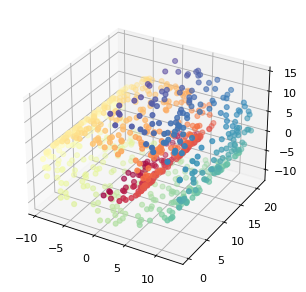

=======Starting joint probabilities matrix======
=======computing distances======
Done!
=======computing sigmas======
Processing row: 0
Processing row: 5
Processing row: 10
Processing row: 15
Processing row: 20
Processing row: 25
Processing row: 30
Processing row: 35
Processing row: 40
Processing row: 45
Processing row: 50
Processing row: 55
Processing row: 60
Processing row: 65
Processing row: 70
Processing row: 75
Processing row: 80
Processing row: 85
Processing row: 90
Processing row: 95
Processing row: 100
Processing row: 105
Processing row: 110
Processing row: 115
Processing row: 120
Processing row: 125
Processing row: 130
Processing row: 135
Processing row: 140
Processing row: 145
Processing row: 150
Processing row: 155
Processing row: 160
Processing row: 165
Processing row: 170
Processing row: 175
Processing row: 180
Processing row: 185
Processing row: 190
Processing row: 195
Processing row: 200
Processing row: 205
Processing row: 210
Processing row: 215
Processing row: 220
Proc

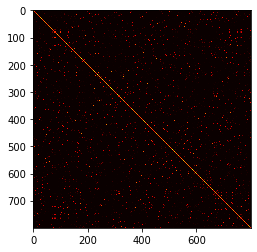

=======Starting TSNE======
=======Starting Gradient Descent======
=======Done!======


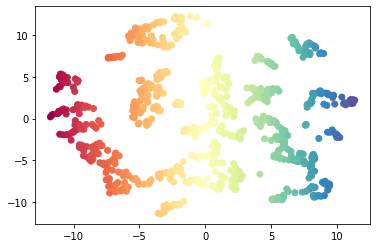

In [18]:

print("In main)")

key = random.PRNGKey(0)
X = random.normal(key,(N,3))
"""
fig = plt.figure(figsize=(10, 10), dpi=80)
color_map = plt.get_cmap('spring')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0],X[:,1],X[:,2],color=color_map)
"""
"""
fig = plt.figure(figsize=(10, 10), dpi=80)
ax = fig.gca(projection='3d')
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())
sc = ax.scatter(X[:,0],X[:,1],X[:,2], s=40, c=X[:,0], marker='o', cmap=cmap, alpha=1)
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.show()
"""
from sklearn import manifold, datasets
import pylab as pl
X, color = datasets.make_swiss_roll(N)
fig = plt.figure(figsize=(10, 10), dpi=80)
ax = fig.add_subplot(211, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=pl.cm.Spectral)
plt.show()

# Obtain matrix of joint probabilities p_ij
P = p_joint(X, PERPLEXITY)
print(P.shape)
print("=======Plotting pij heatmap======")
plt.imshow(P, cmap='hot', interpolation='nearest')
plt.show()

Y = tsne(X, P)

plt.scatter(Y[:,0],Y[:,1],c=Y[:,0],cmap=pl.cm.Spectral)
plt.show()

## Graveyard

In [ ]:
#Depreciated attempt at generating home baked swiss rolls 
"""
def bake_swiss_roll(x,N):
    key = random.PRNGKey(0)
    phi=random.uniform(key,(N,3),np.float32,(1.5*jnp.pi),(4.5*jnp.pi))
    print(phi)
    psi=random.uniform(key,(N,3),np.float32,0,10)
    
    for i in range(x.shape[0]):
        phi_=phi.at[i].get()
        psi_=psi.at[i].get()
        x=x.at[i,:].set( phi_*jnp.cos(phi_), phi_*jnp.sin(phi_),psi_)
        print(x.at[i].get())
    return x
"""